In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from keras import backend as K
K.set_image_data_format('channels_last')

# PatchGAN Discriminator

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(input_shape_3d, output_shape_3d):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input (3D fluorescence)
    in_src_image = Input(shape=input_shape_3d)
    
    # target image input (3D fluorescence)
    in_target_image = Input(shape=output_shape_3d)
    

    # concatenate images channel-wise
    merged = Concatenate(axis=-1)([in_src_image, in_target_image])
    
    # Reshape merged tensor to 5D for Conv3D
    merged = Reshape((1, 128, 128, 12))(merged)
    
    # C64
    d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # model
    model = Model([in_src_image, in_target_image], patch_out)
    
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

# image shapes
input_shape_3d = (128, 128, 6)  # 3D fluorescence image with 5 channels masked
output_shape_3d = (128, 128, 6)  # 3D fluorescence image with 6 channels

# model
model = define_discriminator(input_shape_3d, output_shape_3d)


model.summary()


2024-09-02 11:28:56.651660: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-09-02 11:28:56.651680: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-09-02 11:28:56.651689: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-09-02 11:28:56.651705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-02 11:28:56.651719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope`

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 12)               │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128,    │          0 │ concatenate[0][0] │
│                     │ 128, 12)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 1, 64, 64, │     49,216 │ reshape[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 1, 64, 64, │          0 │ conv3d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 1, 32, 32, │    524,416 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 32, 32, │        512 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 1, 32, 32, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 1, 16, 16, │  2,097,408 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 16, 16, │      1,024 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 1, 16, 16, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 1, 8, 8,   │  8,389,120 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 8, 8,   │      2,048 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 1, 8, 8,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 1, 8, 8,   │ 16,777,728 │ leaky_re_lu_3[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 8, 8,   │      2,048 │ conv3d_4[0][0]  

 Total params: 27,876,289 (106.34 MB)

 Trainable params: 27,873,473 (106.33 MB)

 Non-trainable params: 2,816 (11.00 KB)

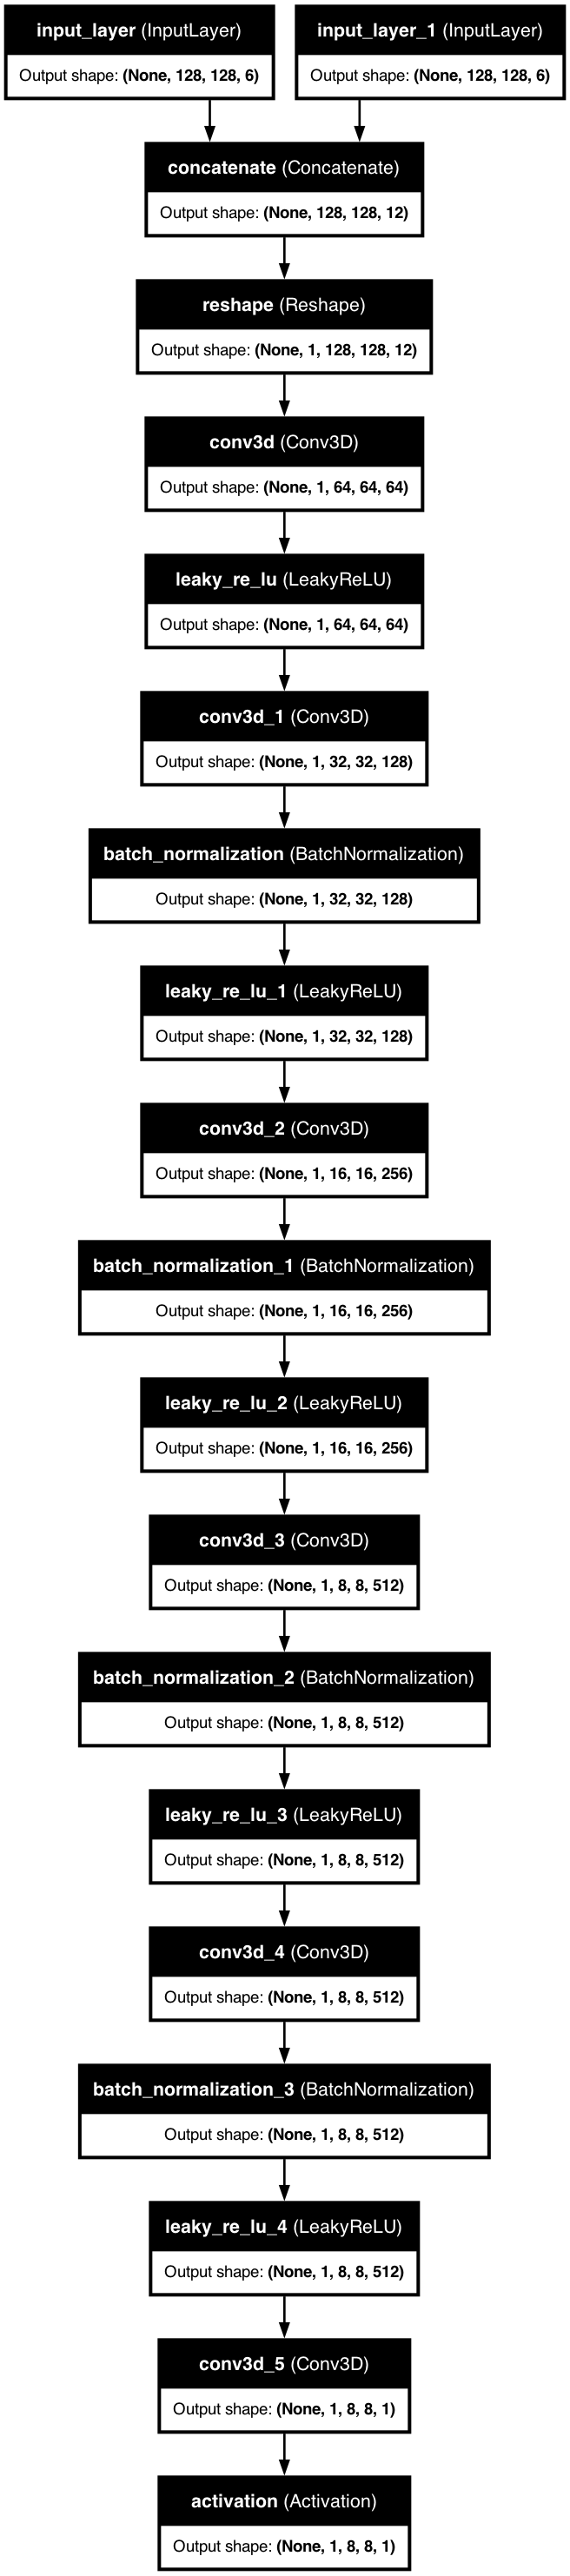

In [4]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf


tf.keras.utils.plot_model(
    model,
    to_file="discriminator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [5]:
from tensorflow.keras.losses import Loss
from tensorflow.image import ssim
import tensorflow as tf

class SSIMLoss(Loss):
    def __init__(self, max_val=1.0, **kwargs):
        super().__init__(**kwargs)
        self.max_val = max_val

    def call(self, y_true, y_pred):
        return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=self.max_val))

    def get_config(self):
        config = super().get_config()
        config.update({"max_val": self.max_val})
        return config


tf.keras.utils.get_custom_objects()['SSIMLoss'] = SSIMLoss



# U-Net Generator

In [6]:

from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU


# encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # batch normalization
    g = BatchNormalization()(g, training=True)
    # dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# standalone generator model
def define_generator(image_shape=(128, 128, 6), output_channels = 6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: 
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(e6)
    b = Activation('relu')(b)
    
    # decoder model: 
    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)
    # output
    out_image = Conv2DTranspose(output_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(d6)
 
    # model
    model = Model(in_image, out_image)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(optimizer='adam', loss=ssim_loss)
    return model

# image shape
image_shape = (128, 128, 6)

output_channels = 6
# create the model
model = define_generator(image_shape, output_channels)

model.summary()



/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      6,208 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 2, 2, 512) │  4,194,816 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 2, 2, 512) │          0 │ batch_normalizat

 Total params: 41,850,502 (159.65 MB)

 Trainable params: 41,842,694 (159.62 MB)

 Non-trainable params: 7,808 (30.50 KB)

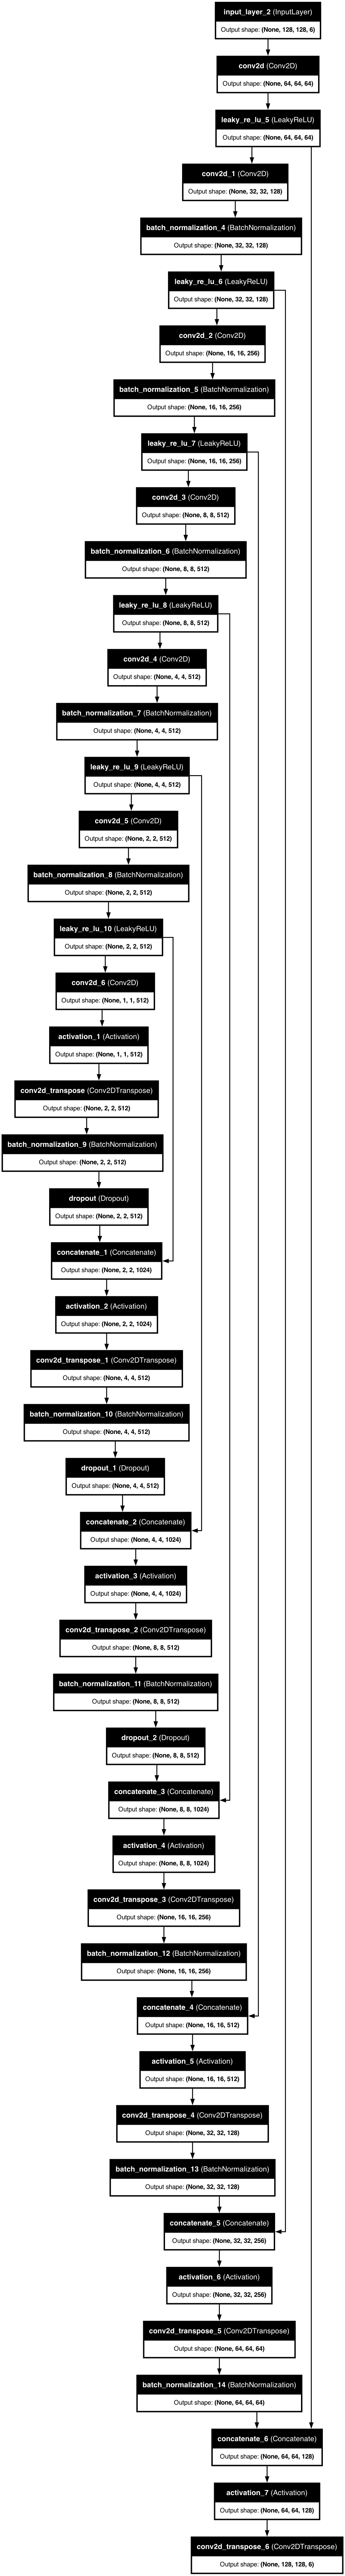

In [7]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf


tf.keras.utils.plot_model(
    model,
    to_file="generator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

In [8]:

# combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    # source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(loss = ['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights = [1,100])
    return model

In [9]:
custom_objects = {'SSIMLoss': SSIMLoss}

/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 128, 128,  │ 41,850,502 │ input_layer_6[0]… │
│ (Functional)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 1, 8, 8,   │ 27,876,289 │ input_layer_6[0]… │
│ (Functional)        │ 1)                │            │ functional_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,726,791 (265.99 MB)

 Trainable params: 69,716,167 (265.95 MB)

 Non-trainable params: 10,624 (41.50 KB)

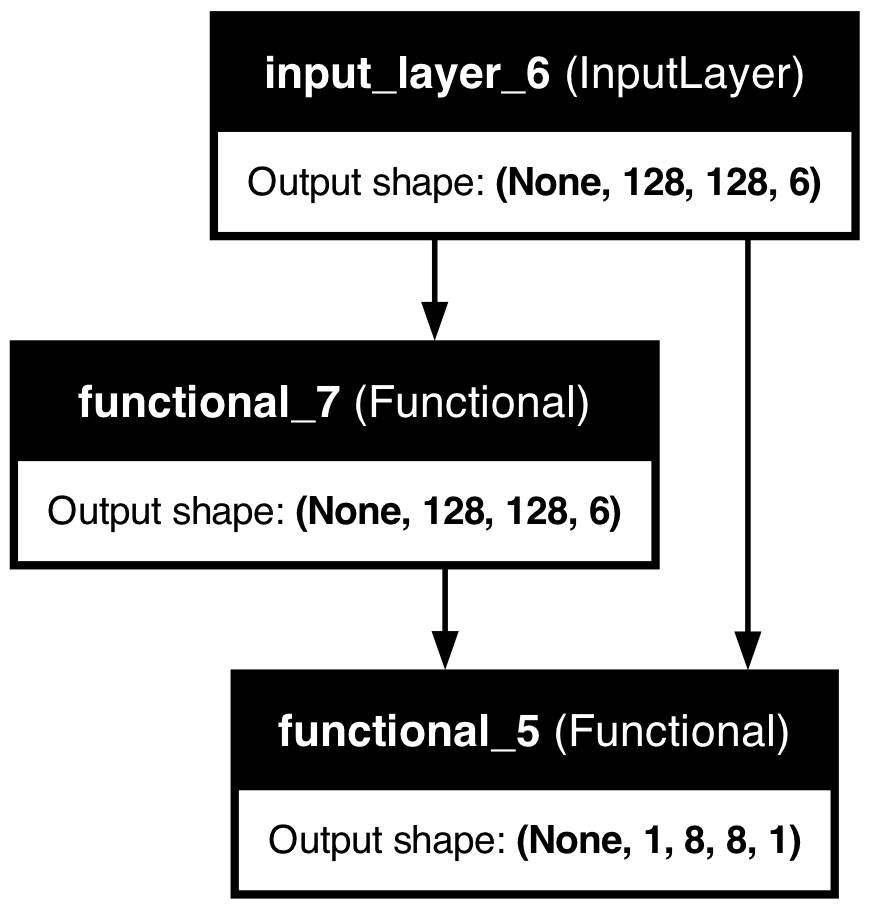

In [10]:
# image shape
image_shape = (128, 128, 6)
output_shape_3d = (128, 128, 6)
# models
d_model = define_discriminator(image_shape, output_shape_3d)
g_model = define_generator(image_shape)
# composite model
gan_model = define_gan(g_model, d_model, image_shape)

gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

# Updating the model weights

In [11]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset1, dataset2, n_samples, patch_shape):
    # unpack dataset
    trainA = dataset1[:, :, :, 1:7]
    trainB = dataset2[:, :, :, 1:7]
    print('trainA shape:', trainA.shape)
    print('trainB shape:', trainB.shape)
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [12]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape): 
    # Ensure samples are in channels_last format

    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),patch_shape, patch_shape, 1))
    return X, y

In [13]:
def brightfield_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 0]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value] 

def channel1_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 1]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]


def channel2_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 2]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value]

def channel3_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 3]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel4_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 4]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel5_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 5]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]



def normalization_process(image, min_val, max_val):
    image = ((image.astype(np.float16) - min_val) / (max_val - min_val)).astype(np.float16)
    image = (image.astype(np.float16)).astype(np.float16)
    return image

In [14]:
def normalization_of_images(images_dataset):
    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])
    
    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])
    
    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])
    
    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])
    
    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])
    
    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

   
    
    
    minimum_value_bf, maximum_value_bf =  brightfield_images(minimum_value_bf, maximum_value_bf, images_dataset) 
    minimum_value_1, maximum_value_1 =  channel1_images(minimum_value_1, maximum_value_1, images_dataset) 
    minimum_value_2, maximum_value_2 =  channel2_images(minimum_value_2, maximum_value_2, images_dataset) 
    minimum_value_3, maximum_value_3 =  channel3_images(minimum_value_3, maximum_value_3, images_dataset) 
    minimum_value_4, maximum_value_4 =  channel4_images(minimum_value_4, maximum_value_4, images_dataset) 
    minimum_value_5, maximum_value_5 =  channel5_images(minimum_value_5, maximum_value_5, images_dataset) 
 
    
   
    
    
    for i in range(images_dataset.shape[0]):
        for j in range(images_dataset.shape[-1]):
            if(j==0):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_bf, maximum_value_bf)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==1):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_1)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==2):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_2)
                images_dataset[i, :, :, j] = temp_image
            
            if(j==3):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_3)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==4):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_4)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==5):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_5)
                images_dataset[i, :, :, j] = temp_image

            
        
    # To print min and max after normalization
    """
    
                
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 

    
    print("shape of normalized images dataset = ", images_dataset.shape)
    #print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    """
    
    return images_dataset
    

In [15]:
def min_and_max_images(images_dataset):    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])

    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])

    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])

    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])

    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])

    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    
    # To check min and max values of pixels 
    """
    
                    
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
   
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    """

In [16]:

# model compilation for multiple outputs
d_model.compile(optimizer='Adam', loss='binary_crossentropy')
d_model.trainable = True



In [17]:

# Defining the optimizer and compile the GAN model
from keras.optimizers import SGD
 
opt = Adam(learning_rate=0.0002)
ssim_loss = SSIMLoss(max_val=1.0)
gan_model.compile(loss=['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights=[1, 100])



In [18]:
import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, g_model, d_model, gan_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        super(CustomModelCheckpoint, self).__init__()
        self.g_model = g_model
        self.d_model = d_model
        self.gan_model = gan_model
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.best = float('inf') if mode == 'min' else float('-inf')
        self.monitor_op = np.less if mode == 'min' else np.greater
        if mode not in ['auto', 'min', 'max']:
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = float('-inf')
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = float('-inf')
            else:
                self.monitor_op = np.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            current = logs.get(self.monitor)
            if isinstance(current, list):
                current = current[0]  # Assuming the first value is what you want
            if current is None:
                warnings.warn(f'Can save best model only with {self.monitor} available, skipping.', RuntimeWarning)
            else:
                if self.save_best_only:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {self.filepath}')
                        self.best = current
                        self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)
                    else:
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}')
                else:
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: saving model to {self.filepath}')
                    self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)

    def _save_model(self, filepath, overwrite=True):
        if self.save_weights_only:
            self.g_model.save_weights(filepath + '_generator.h5', overwrite=overwrite)
            self.d_model.save_weights(filepath + '_discriminator.h5', overwrite=overwrite)
            self.gan_model.save_weights(filepath + '_gan.h5', overwrite=overwrite)
        else:
            self.g_model.save(filepath + '_generator.keras', overwrite=overwrite)
            self.d_model.save(filepath + '_discriminator.keras', overwrite=overwrite)
            self.gan_model.save(filepath + '_gan.keras', overwrite=overwrite)

In [19]:
import os
import shutil

# Uncomment the following when you want to delete previous checkpoints and train model from scratch
# Make sure to comment again after executing the code


# Clear previous checkpoints
"""
checkpoint_dir = 'checkpoints_masked'
if os.path.exists(checkpoint_dir):
    print("checkpoint directory exists")
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)
"""

'\ncheckpoint_dir = \'checkpoints_masked\'\nif os.path.exists(checkpoint_dir):\n    print("checkpoint directory exists")\n    shutil.rmtree(checkpoint_dir)\nos.makedirs(checkpoint_dir)\n'

In [20]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

checkpoint_dir = 'checkpoints_masked'

os.makedirs(checkpoint_dir, exist_ok=True)

In [21]:
latest_checkpoint = None

# Find the latest checkpoint file for each model
generator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_generator.keras'))
discriminator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_discriminator.keras'))
gan_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_gan.keras'))

if generator_checkpoints and discriminator_checkpoints and gan_checkpoints:
    latest_generator = max(generator_checkpoints, key=os.path.getctime)
    latest_discriminator = max(discriminator_checkpoints, key=os.path.getctime)
    latest_gan = max(gan_checkpoints, key=os.path.getctime)
    
    print(f"Found checkpoints:\nGenerator: {latest_generator}\nDiscriminator: {latest_discriminator}\nGAN: {latest_gan}")
    latest_checkpoint = True
else:
    print("No complete set of checkpoints found. Starting from scratch.")
    latest_checkpoint = None

Found checkpoints:
Generator: checkpoints_masked/model_checkpoint_20_11.89_generator.keras
Discriminator: checkpoints_masked/model_checkpoint_20_11.89_discriminator.keras
GAN: checkpoints_masked/model_checkpoint_20_11.89_gan.keras


In [22]:
input_shape_3d = (128, 128, 6)
output_shape_3d = (128, 128, 6)
image_shape = (128, 128, 6)


In [23]:
import os
import tensorflow as tf

starting_epoch = 0
if latest_checkpoint:
    print("Loading weights from checkpoints...")
    try:
        # Load weights for each model separately
        g_model.load_weights(latest_generator)
        d_model.load_weights(latest_discriminator)
        gan_model.load_weights(latest_gan)
        epoch_str = os.path.basename(latest_generator).split('_')[2]
        starting_epoch = int(epoch_str)
        print(f"Resuming from epoch {starting_epoch}")
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {str(e)}")
        print("Initializing models with random weights.")
        # If loading fails, we'll start with fresh models
        g_model = define_generator(image_shape)
        d_model = define_discriminator(input_shape_3d, output_shape_3d)
        gan_model = define_gan(g_model, d_model, image_shape)

# Create the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint(
    g_model=g_model,
    d_model=d_model,
    gan_model=gan_model,
    filepath=os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}_{val_loss:.2f}'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=20
)


Loading weights from checkpoints...
Error loading weights: File is not a zip file
Initializing models with random weights.


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [24]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path_in,file_path_ou, batch_size, patch_shape, generator_model):
        
        self.file_path_in = file_path_in
        self.file_path_ou = file_path_ou
        self.batch_size = batch_size
        self.patch_shape = patch_shape
       
      
        
        self.data1 = np.load(self.file_path_in)['array']
        self.data1 = self.data1.astype(np.float16)
        if(flag == 1):
            self.data1 = self.data1[4000:4500]
        else:
            self.data1 = self.data1[:2000]
        print(self.data1.shape)
        np.savez('modified_data1.npz', array=self.data1)
        del self.data1
        self.data2 = np.load(self.file_path_ou)['array']
        self.data2 = self.data2.astype(np.float16)
        if(flag == 1):
            self.data2 = self.data2[4000:4500]
        else:
            self.data2 = self.data2[:2000]
        print(self.data2.shape)
        np.savez('modified_data2.npz', array=self.data2)
        del self.data2
        self.data1 = np.load('modified_data1.npz')['array']
        self.data2 = np.load('modified_data2.npz')['array']
        self.data1 = self.data1[..., 1:7]
        self.data2 = self.data2[..., 1:7]
        self.data1 = normalization_of_images(self.data1)
        self.data2 = normalization_of_images(self.data2)

        self.indices = np.arange(self.data1.shape[0])
        self.generator_model = generator_model
        self.trainA = self.data1
        self.trainB = self.data2
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.trainA) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        X_realA, X_realB, y_real, X_fakeB, y_fake = self.__data_generation(indexes)
        return [X_realA, X_realB], [y_real, X_fakeB, y_fake]


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.trainA))
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generate real samples
        X_realA, X_realB = self.trainA[indexes], self.trainB[indexes]
        y_real = np.ones((self.batch_size, self.patch_shape, self.patch_shape, 1))

        # Generate fake samples
        X_fakeB = self.generator_model.predict(X_realA)
        y_fake = np.zeros((self.batch_size, self.patch_shape, self.patch_shape, 1))



        return X_realA, X_realB, y_real, X_fakeB, y_fake


In [25]:
import tensorflow as tf

def calculate_ssim_loss(real_images, generated_images):
    
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    
    # Calculating SSIM scores
    ssim_scores = tf.image.ssim(real_images, generated_images, max_val=1.0)
    
    # Calculating mean SSIM score
    mean_ssim = tf.reduce_mean(ssim_scores)
    
    # Converting SSIM to loss (1 - SSIM)
    ssim_loss = 1 - mean_ssim
    
    return ssim_loss


In [26]:
import os

file_pathin = 'masked_dataset.npz'
file_pathou = 'fluor_images_transposed_asnumpy.npz'
if os.path.exists(file_pathin):
    print(f"File found: {file_pathin}")
  
else:
    print(f"File not found: {file_pathin}")
   
    
if os.path.exists(file_pathou):
    print(f"File found: {file_pathou}")
    
else:
    print(f"File not found: {file_pathou}")
   

File found: masked_dataset.npz
File found: fluor_images_transposed_asnumpy.npz


# Training

In [27]:
flag = 0

In [28]:
batch_size = 16
patch_shape = 8  

data_gen = DataGenerator('masked_dataset.npz', 'fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)


(2000, 128, 128, 7)
(2000, 128, 128, 7)


In [ ]:
[X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[1]

In [ ]:
print("X_realA: ", X_realA.shape)
print("X_realB", X_realB.shape)
print("X_fakeB", X_fakeB.shape)
print("y_real", y_real.shape)
print("y_fake", y_fake.shape)

In [ ]:

epochs = 50




# Training loop
for epoch in range(starting_epoch, epochs):
    for batch in range(len(data_gen)):
        [X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[batch]
        
        # Training the discriminator
        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Training the generator
        g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # Calculate SSIM loss
        ssim_loss = calculate_ssim_loss(X_realB, X_fakeB)
        
        print(f'Epoch {epoch+1}, Batch: {batch+1}, SSIM Loss: {ssim_loss}')
        print(f"Epoch: {epoch+1}, Batch: {batch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")
      
        
    custom_checkpoint.on_epoch_end(epoch, logs={'val_loss': g_loss})
    # Clear the Keras session
    tf.keras.backend.clear_session()

# Ensure to call on_train_end at the end of training
custom_checkpoint.on_train_end(logs={})

In [ ]:
plt.figure(figsize=(20, 20))
print(X_realB.shape)
for j in range(X_realA.shape[-1]):
    img = X_fakeB[10,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()

In [ ]:

plt.figure(figsize=(20, 20))
print(X_fakeB.shape)
for j in range(X_fakeB.shape[-1]):
    img = X_fakeB[10,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()


# Validation

In [27]:
flag = 1

In [28]:
batch_size = 16
patch_shape = 8  


data_gen_validation = DataGenerator('masked_dataset.npz','fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)

d_losses_real = []
d_losses_fake = []
g_losses = []

(500, 128, 128, 7)
(500, 128, 128, 7)


In [29]:
[X_realA_val, X_realB_val], [y_real_val, X_fakeB_val, y_fake_val] = data_gen_validation[1]

2024-09-01 22:11:11.394877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-01 22:11:12.976839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2024-09-01 22:11:14.853366: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 7s 7s/step


In [30]:
print("X_realA_val: ", X_realA_val.shape)
print("X_realB_val", X_realB_val.shape)
print("X_fakeB_val", X_fakeB_val.shape)
print("y_real_val", y_real_val.shape)
print("y_fake_val", y_fake_val.shape)


X_realA_val:  (16, 128, 128, 6)
X_realB_val (16, 128, 128, 6)
X_fakeB_val (16, 128, 128, 6)
y_real_val (16, 8, 8, 1)
y_fake_val (16, 8, 8, 1)


In [33]:


for batch in range(0, len(data_gen_validation), batch_size):
    [X_realA_val, X_realB_val], [y_real_val, X_fakeB_val, y_fake_val] = data_gen_validation[batch]

   
    d_loss_real = d_model.test_on_batch([X_realA_val, X_realB_val], y_real_val)
    d_loss_fake = d_model.test_on_batch([X_realA_val, X_fakeB_val], y_fake_val)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losses_real.append(d_loss_real)
    d_losses_fake.append(d_loss_fake)

    
    g_loss = gan_model.test_on_batch(X_realA_val, [y_real_val, X_realB_val])
    g_losses.append(g_loss)

   
    ssim_loss = calculate_ssim_loss(X_realB_val, X_fakeB_val)

    print(f'Batch: {batch+1}, SSIM Loss: {ssim_loss}')
    
      
        
    
    
    tf.keras.backend.clear_session()



1/1 [==============================] - 0s 136ms/step


2024-09-01 22:11:56.018945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-01 22:11:56.484214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/model_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch: 1, SSIM Loss: 0.11170899868011475
1/1 [==============================] - 0s 135ms/step


2024-09-01 22:11:56.878510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-01 22:11:57.276810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/model_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch: 17, SSIM Loss: 0.12295997142791748


(16, 128, 128, 6)
0.035271578 0.086250365
0.01794734 0.11335443
0.008396937 0.12796707
0.006562952 0.053439762
0.072569884 0.26850462
-0.029533476 0.020302266


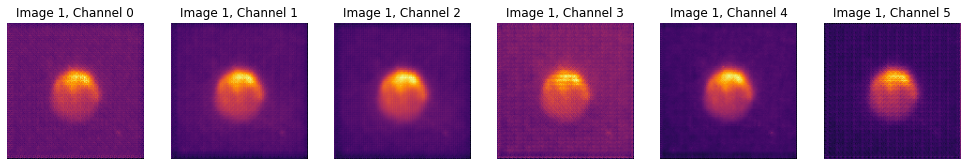

In [35]:
plt.figure(figsize=(20, 20))
print(X_fakeB_val.shape)
for j in range(X_fakeB_val.shape[-1]):
    img = X_fakeB_val[10,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()